In [1]:
import numpy as np
import os
import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt

import sys
from pathlib import Path
from scipy.signal import butter, lfilter

import json
import commentjson
import pickle
import scipy.io as sio
from pathlib import Path
import numpy as np

In [2]:
def parse_txt(text_lines):
    time, ch1, ch2 = [], [], []
    for i, line in enumerate(text_lines):
        if i < 6:
            continue
        line = line.split("; ")
        try:
            time.append(float(line[0]))
            ch1.append(float(line[1]))
            ch2.append(float(line[2]))
        except:
            print("End line at {} ".format(i))
            break
    return np.asarray(time), np.asarray(ch1), np.asarray(ch2)

def load_text(path):
    with open(path) as f:
        return [l.replace("\n", "") for l in f.readlines()]

In [3]:
#generate data
data_path = "../data/meas_scope_20210823.txt"
time, raw_data, triangle_waves = parse_txt(load_text(data_path))
root_dir = os.path.split(data_path)[0]

End line at 2537861 


In [4]:
def cyc_searching (data,window):
    temp_max =0 ;
    i=0
    ind_min= 0;
    ind_max=0;
    A = data[0:window];
    B = data[window+1:2*window+1];
    if((np.max(B)-np.max(A))>0):
        direct ="up";
    else:
        direct = "down"
    collect = []
    while(1):
        A = data[i:i+window];
        B = data[i+window+1:i+2*window+1];
        if ((np.max(B)-np.max(A)) == 0): i=i+window;
        if(direct == "up"):
            #start collect
            if((np.max(B)-np.max(A))>0):       
                i=i+window;
                if((i+2*window+1)>len(data)): return collect;
            else:            
                ind_max=i+np.argmax(A)
                direct = "down";
                
        if(direct == "down"):        
            if((np.min(A)- np.min(B))>0):
                i=i+window;
                if((i+2*window+1)>len(data)): return  collect;
            else:
                ind_min=i+np.argmin(A)
                collect.append([ind_max,ind_min])
                direct = "up"

# Create pzt_index

In [5]:
window = 4000
ind = cyc_searching(triangle_waves,window)

# Load 柏安Data

In [6]:
signal_det_path = "../data/det_idxs.npy"
signal_det= np.load(signal_det_path )

# Simulator & test

In [7]:
# trim the package due to evey package has different length to plot
def do_trim_package(ds):
    min_l=0xffffffff
    for num in range(len(ds)):
        l = len(ds[num][1])
        if(min_l>l): 
            min_l = l  
    if(min_l==0xffffffff):
        print("trim_error")     
    else:
        for num in range(len(ds)):
            ds[num][1] = ds[num][1][0:min_l]
            ds[num][2] = ds[num][2][0:min_l]
    
# rearrange all data and det_sig with 0 - lens
# for seeing every scanning as a single experiment
# the det_sig marked as 1 ; elsewhere as 0; 
def package_generator(pzt_ind, raw_data, det_peaks):
    ds = []
    for num in range(len(pzt_ind)):

        tmp_data=[]        
        first_ind = pzt_ind[num][0]
        final_ind = pzt_ind[num][1]
        tmp_data = raw_data[pzt_ind[num][0]:pzt_ind[num][1]]
        
        tmp_peaks=np.zeros(len(tmp_data))
        for peak in det_peaks:
            if ((peak>first_ind) & (peak < final_ind)):
                tmp_peaks[peak-first_ind] = 1 #marked
        ds.append([num, tmp_data, tmp_peaks])
    return ds


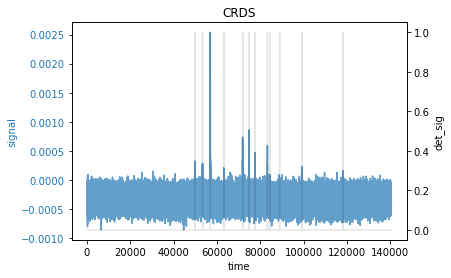

In [8]:
ds = package_generator(ind,raw_data,signal_det)
do_trim_package(ds)

num =2 
data_len = len(ds[num][1])
x= np.arange(0, data_len,1)
y1 = ds[num][1]
y2 = ds[num][2]

fig, ax1 = plt.subplots()
plt.title('CRDS')
plt.xlabel('time')
ax2 = ax1.twinx()
ax1.set_ylabel('signal', color='tab:blue')

ax1.plot(x,y1, color='tab:blue', alpha=0.7) 
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2.set_ylabel('det_sig', color='black')
ax2.plot(x, y2, color='black', alpha=0.1)
ax2.tick_params(axis='y', labelcolor='black')

# SSF Programing test

In [9]:
#設定: 預判的peaks
#假設我已知大約的 comb spacing 例如: 3000
def init_virtual_peaks(ds_t0, combspac):
    #初始化
    vs_t0=np.zeros(len(ds_t0))
    pt = _find_peaks(ds_t0,0)
    while(pt<len(vs_t0)):       
        vs_t0[pt] = 1
        pt =  pt + combspac
    return vs_t0

def update_virtual_peaks(ds_t, vs_t, width,combspac):
       
    vs_tmp = init_virtual_peaks(ds_t,3000)
    p1 = _find_peaks(vs_t ,0)
    p2 = _find_peaks(vs_tmp ,0)
    edge = len(vs_tmp)- 2 * width
    
    if(p2>p1): 
        pt = p1
        print("case1")
        
        if (pt - width <0):
            print("update error: pt - width <0 ")
            return -1 
        count=0
        
        while(pt!=-1):
            for w in range(width):
                if(vs_tmp[pt - width + 2 * w] == 1):
                        #reset
                        vs_t[pt] = 0
                        #update: (pt + (pt - width + 2*w))/2
                        vs_t[(pt- round(width/2) + w)] = 1            

            count = count + 1;
            pt = _find_peaks(vs_t,count)
            
        return vs_t
    else:
        pt = p2
        print("case2")
    
        if (pt - width <0):
            print("update error: pt - width <0 ")
            return -1 

        while(pt < edge):
            for w in range(width):
                if(vs_t[pt - width + 2 * w] == 1):
                        #reset
                        vs_tmp[pt] = 0
                        #update: (pt + (pt - width + 2*w))/2
                        vs_tmp[pt- round(width/2) + w] = 1            


            pt = pt + combspac
        return vs_tmp


    
    
def _count_peaks(vs_t):
    count =0
    for i in range(len(vs_t)):
        if(vs_t[i]):
            count = count+1
    if(count==0): print("warning: no peak")
    return count

def _find_peaks(vs_t,pt):
    count =0;
    for i in range(len(vs_t)):
        if(vs_t[i] == 1):            
            if(count == pt):
                return i
            else:                
                count = count + 1
    return -1

#  T = t0

In [32]:
combspac = 2700

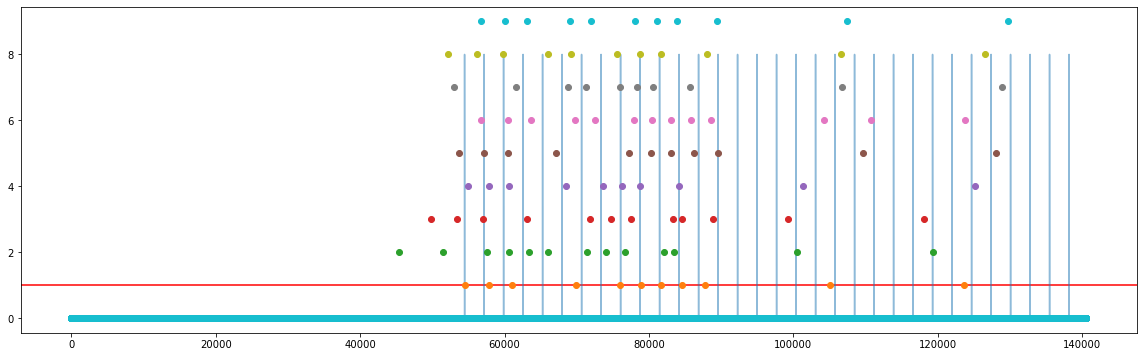

In [34]:
n=0
ds_t0= ds[0][2]
vs_t = init_virtual_peaks(ds_t0,combspac)

data_len = len(ds[n][1])
x= np.arange(0, data_len,1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
plt.axhline(y=n+1, color='r', linestyle='-')
plt.plot(x,vs_t*8, alpha=0.5)
for num in range(len(ds)):
    y = ds[num][2] *(num+1)
    plt.plot(x,y, 'o')   

# T=t1

case2


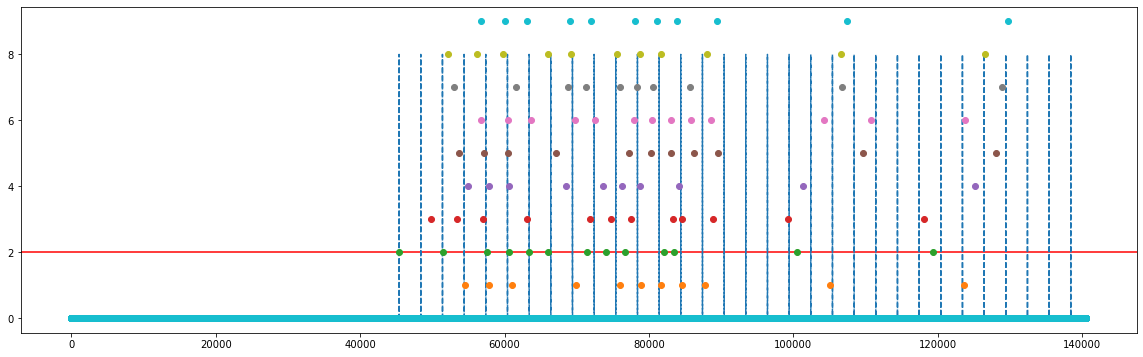

In [35]:
n=1
ds_t = ds[n][2]
vs_t = update_virtual_peaks(ds_t,vs_t,500,combspac)

data_len = len(ds[n][1])
x= np.arange(0, data_len,1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
plt.axhline(y=n+1, color='r', linestyle='-')
plt.plot(x,vs_t*8,'--')
for num in range(len(ds)):
    y = ds[num][2] *(num+1)
    plt.plot(x,y, 'o')   

# T=t2

case1


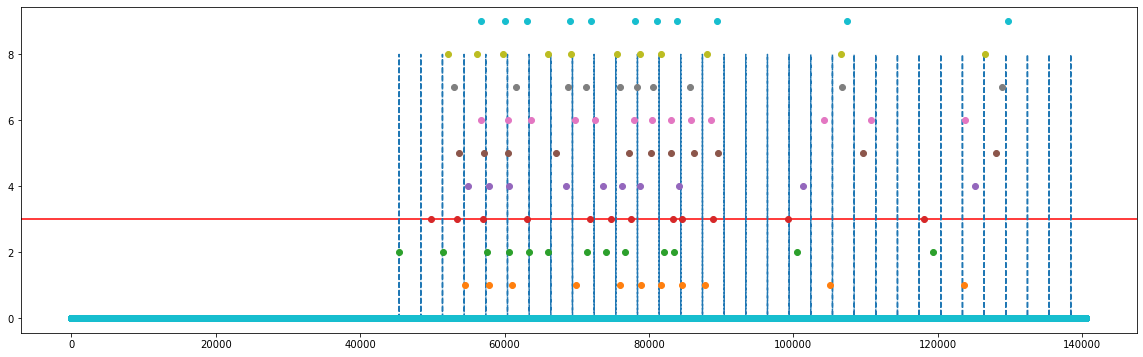

In [36]:
n=2
ds_t = ds[n][2]
vs_t = update_virtual_peaks(ds_t,vs_t,500,combspac)

data_len = len(ds[num][1])
x= np.arange(0, data_len,1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
plt.axhline(y=n+1, color='r', linestyle='-')
plt.plot(x,vs_t*8,'--')
for num in range(len(ds)):
    y = ds[num][2] *(num+1)
    plt.plot(x,y, 'o')   

case1
case2
case1
case1
case1
case1
case1
case1
case1


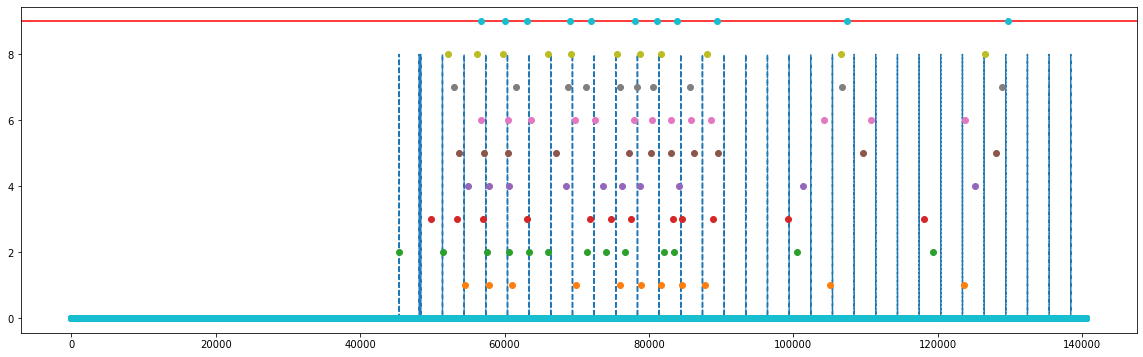

In [38]:
for n in range(len(ds)):
    ds_t = ds[n][2]
    vs_t = update_virtual_peaks(ds_t,vs_t,300,combspac)

data_len = len(ds[num][1])
x= np.arange(0, data_len,1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(6)
plt.axhline(y=n+1, color='r', linestyle='-')
plt.plot(x,vs_t*8,'--')
for num in range(len(ds)):
    y = ds[num][2] *(num+1)
    plt.plot(x,y, 'o')   

In [ ]:
#1. 需增加weight
#2. 若最低根是noise 怎麼判別?
#3. 請伯安增加 confidence or uncertainty

In [ ]:
from math import *

def f(mu, sigma2, x):
    return 1/sqrt(2.*pi*sigma2) * exp(-.5*(x-mu)**2 / sigma2)

def update(mean1, var1, mean2, var2):
    new_mean = (mean1*var2+mean2*var1)/(var1+var2)
    new_var =1/(1/var1+1/var2)
    return [new_mean, new_var]